In [52]:
import astropy
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import LogNorm
from astropy import units as u
import galpy
from galpy.orbit import Orbit
from astropy.coordinates import SkyCoord
from galpy.potential import MWPotential2014
from astropy.coordinates import SkyCoord, Galactocentric, CartesianDifferential
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse, Circle
import astropy.units as u
from astropy.coordinates import ICRS
import astropy.coordinates as apycoords
from astropy.coordinates import CylindricalRepresentation, CylindricalDifferential

In [48]:
vphi_data = 'vphi_dataset.fits'

with fits.open(vphi_data) as hdul:
    data = hdul[1].data  
    
    df_vphi = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name]
                       for col in hdul[1].columns})

In [49]:
pd.set_option('display.max_columns', None)

df_vphi.head()

,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ruwe,radial_velocity,radial_velocity_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,catwise_w1,catwise_w2,mh_xgboost,teff_xgboost,logg_xgboost,in_training_sample,col1,col2,Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo_x,B_rgeo_xa,rpgeo,b_rpgeo_x,B_rpgeo_xa,Flag,angDist,fpu,E(B-V),R_gal,phi_gal,Z_gal,v_phi
0,15741055975040,176.739184,-48.572035,45.136038,0.335043,1.439792,0.018947,-0.711280,0.017718,-1.412098,0.016528,1.036041,-0.738894,0.316921,10.254021,10.750235,9.595748,8.152,8.198,-0.144,5065.8,2.993,True,45.136038,0.335043,15741055975040,45.136038,0.335043,695.683899,683.627625,707.396423,696.278320,688.270874,707.143982,10033,0.0,0.013160,0.104689,470.485258,0.055731,-520.632142,243.095762
1,66627828480768,176.483565,-48.171322,45.305053,0.736093,0.534038,0.020692,3.309832,0.022959,1.594356,0.022822,1.349013,41.607450,1.323430,10.508830,11.150953,9.741709,7.891,7.964,-0.401,4499.0,1.916,False,45.305053,0.736093,66627828480768,45.305053,0.736093,1884.275020,1821.247560,1947.302730,1883.143550,1807.318600,1944.665770,10033,0.0,0.038747,0.093026,1268.325930,0.060773,-1399.358389,237.364263
2,82467667849472,176.209301,-48.607026,44.866246,0.561503,2.209985,0.016049,-4.869755,0.015797,-12.678339,0.013950,1.018742,-32.461674,0.205614,10.651456,11.169626,9.980610,8.496,8.558,0.114,4938.3,3.203,True,44.866246,0.561503,82467667849472,44.866246,0.561503,452.636078,448.701294,456.615540,452.602692,449.257355,455.432892,10033,0.0,0.007262,0.086075,308.483632,0.064184,-338.602406,230.329127
3,101193725229056,175.755174,-48.727781,44.569524,0.689953,0.528788,0.024241,3.539184,0.027864,-1.599436,0.021891,1.176748,91.295900,4.830661,14.332739,14.816101,13.685076,12.220,12.275,-0.478,4980.2,3.319,False,44.569524,0.689953,101193725229056,44.569524,0.689953,1908.478270,1815.024170,2014.483890,1868.603880,1800.940800,1949.831300,10033,0.0,0.045842,0.078062,1245.041147,0.073347,-1400.635394,217.472712
4,130399502833792,175.789759,-48.328584,44.868872,0.955080,0.847929,0.017479,3.382907,0.017619,-0.291235,0.015982,1.087555,1.959265,0.328298,11.215295,11.810178,10.481738,8.728,8.815,-0.159,4643.6,2.398,True,44.868872,0.955080,130399502833792,44.868872,0.955080,1178.407470,1155.319820,1203.711180,1177.687260,1154.219600,1201.322750,10033,0.0,0.020614,0.077163,793.842786,0.072479,-877.288236,231.337541


In [53]:
# Define the Galactocentric frame with Sun's motion
v_sun = CartesianDifferential([11.1, 245., 7.25] * u.km / u.s)  # Sun's motion relative to the Galactic center
gc_frame = Galactocentric(galcen_distance=8.1 * u.kpc,  # Distance from the Sun to the Galactic center
                                    z_sun=25. * u.pc,  # Distance of the Sun above the Galactic midplane
                                    galcen_v_sun=v_sun)  # Velocity of the Sun
                                    

# Extract the columns as numpy arrays from your DataFrame
ra = df_vphi['ra'].values * u.deg
dec = df_vphi['dec'].values * u.deg
distance = df_vphi['rpgeo'].values * u.pc  # Assuming rpgeo is in parsecs
pmra = df_vphi['pmra'].values * u.mas / u.yr
pmdec = df_vphi['pmdec'].values * u.mas / u.yr
vlos = df_vphi['radial_velocity'].values * u.km / u.s

# Create a SkyCoord object for all sources at once (ICRS coordinates)
coords = ICRS(ra=ra, dec=dec, distance=distance, pm_ra_cosdec=pmra, pm_dec=pmdec, radial_velocity=vlos)

# Transform all coordinates to the Galactocentric frame
cg = coords.transform_to(gc_frame)
cg.representation= 'cylindrical'

In [54]:
# Convert to cylindrical representation
cg_cyl = cg.represent_as(CylindricalRepresentation)

# Extract the velocity differentials
cg_cyl_vel = cg.represent_as(CylindricalRepresentation, CylindricalDifferential).differentials['s']

In [55]:
# Convert d_rho to km/s
v_r_kms = cg_cyl_vel.d_rho.to(u.km / u.s)

# Convert d_rho to km/s
df_vphi['v_R'] = cg_cyl_vel.d_rho.to(u.km / u.s).value

In [56]:
df_vphi.head()

,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ruwe,radial_velocity,radial_velocity_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,catwise_w1,catwise_w2,mh_xgboost,teff_xgboost,logg_xgboost,in_training_sample,col1,col2,Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo_x,B_rgeo_xa,rpgeo,b_rpgeo_x,B_rpgeo_xa,Flag,angDist,fpu,E(B-V),R_gal,phi_gal,Z_gal,v_phi,v_R
0,15741055975040,176.739184,-48.572035,45.136038,0.335043,1.439792,0.018947,-0.711280,0.017718,-1.412098,0.016528,1.036041,-0.738894,0.316921,10.254021,10.750235,9.595748,8.152,8.198,-0.144,5065.8,2.993,True,45.136038,0.335043,15741055975040,45.136038,0.335043,695.683899,683.627625,707.396423,696.278320,688.270874,707.143982,10033,0.0,0.013160,0.104689,470.485258,0.055731,-520.632142,243.095762,-14.428048
1,66627828480768,176.483565,-48.171322,45.305053,0.736093,0.534038,0.020692,3.309832,0.022959,1.594356,0.022822,1.349013,41.607450,1.323430,10.508830,11.150953,9.741709,7.891,7.964,-0.401,4499.0,1.916,False,45.305053,0.736093,66627828480768,45.305053,0.736093,1884.275020,1821.247560,1947.302730,1883.143550,1807.318600,1944.665770,10033,0.0,0.038747,0.093026,1268.325930,0.060773,-1399.358389,237.364263,42.346437
2,82467667849472,176.209301,-48.607026,44.866246,0.561503,2.209985,0.016049,-4.869755,0.015797,-12.678339,0.013950,1.018742,-32.461674,0.205614,10.651456,11.169626,9.980610,8.496,8.558,0.114,4938.3,3.203,True,44.866246,0.561503,82467667849472,44.866246,0.561503,452.636078,448.701294,456.615540,452.602692,449.257355,455.432892,10033,0.0,0.007262,0.086075,308.483632,0.064184,-338.602406,230.329127,-51.045366
3,101193725229056,175.755174,-48.727781,44.569524,0.689953,0.528788,0.024241,3.539184,0.027864,-1.599436,0.021891,1.176748,91.295900,4.830661,14.332739,14.816101,13.685076,12.220,12.275,-0.478,4980.2,3.319,False,44.569524,0.689953,101193725229056,44.569524,0.689953,1908.478270,1815.024170,2014.483890,1868.603880,1800.940800,1949.831300,10033,0.0,0.045842,0.078062,1245.041147,0.073347,-1400.635394,217.472712,62.829005
4,130399502833792,175.789759,-48.328584,44.868872,0.955080,0.847929,0.017479,3.382907,0.017619,-0.291235,0.015982,1.087555,1.959265,0.328298,11.215295,11.810178,10.481738,8.728,8.815,-0.159,4643.6,2.398,True,44.868872,0.955080,130399502833792,44.868872,0.955080,1178.407470,1155.319820,1203.711180,1177.687260,1154.219600,1201.322750,10033,0.0,0.020614,0.077163,793.842786,0.072479,-877.288236,231.337541,1.866465


In [57]:
data_array = np.array(
    list(df_vphi.itertuples(index=False, name=None)),
    dtype=[(col, df_vphi[col].dtype.type) for col in df_vphi.columns]
)

hdu = fits.BinTableHDU(data_array)

output_fits_filename = 'v_dataset.fits'
hdu.writeto(output_fits_filename, overwrite=True)

print(f"FITS file saved as '{output_fits_filename}'")

FITS file saved as 'v_dataset.fits'


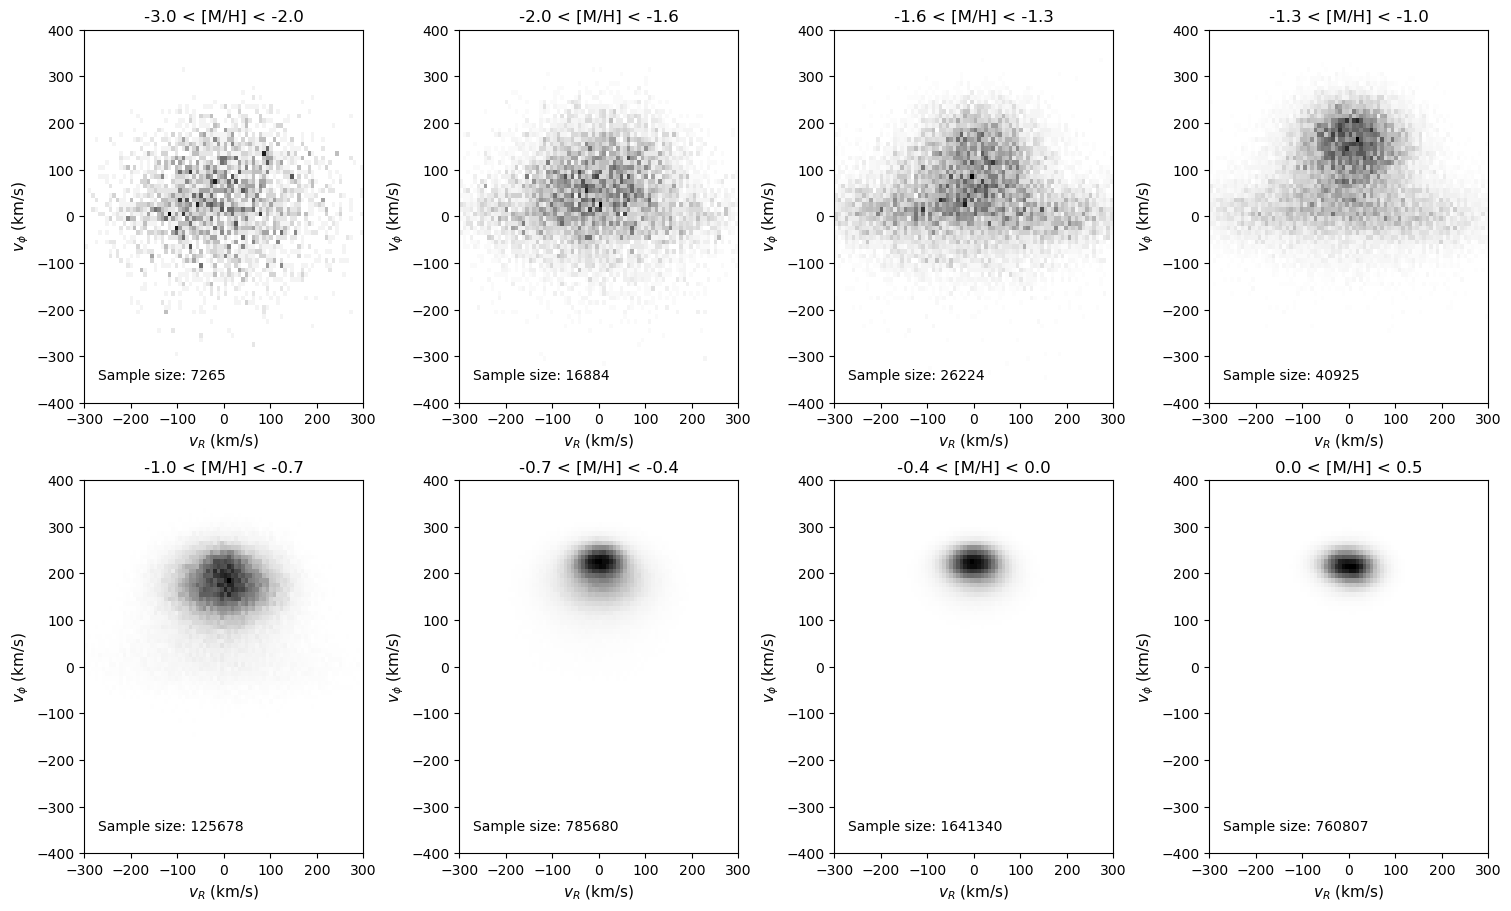

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Define metallicity bins and labels
metallicity_bins = [-3.0, -2.0, -1.6, -1.3, -1.0, -0.7, -0.4, 0.0, 0.5]
bin_labels = [
    "-3.0 < [M/H] < -2.0",
    "-2.0 < [M/H] < -1.6",
    "-1.6 < [M/H] < -1.3",
    "-1.3 < [M/H] < -1.0",
    "-1.0 < [M/H] < -0.7",
    "-0.7 < [M/H] < -0.4",
    "-0.4 < [M/H] < 0.0",
    "0.0 < [M/H] < 0.5"
]

# Define binning parameters
bins = 80
vR_range = (-300, 300)  # Adjusted to match the provided plot
vPhi_range = (-400, 400)

# Create a figure with subplots (2 rows, 4 columns) without shared axes
fig, axes = plt.subplots(2, 4, figsize=(15, 9), constrained_layout=True)

# Loop through metallicity bins and plot
for i, (low, high) in enumerate(zip(metallicity_bins[:-1], metallicity_bins[1:])):
    df_filtered = df_vphi[(df_vphi["mh_xgboost"] > low) & (df_vphi["mh_xgboost"] <= high)]
    
    # Compute 2D histogram
    H, xedges, yedges = np.histogram2d(
        df_filtered["v_R"], 
        df_filtered["v_phi"], 
        bins=bins, range=[vR_range, vPhi_range], density=True
    )

    # Normalize the histogram (min-max scaling)
    H_min = np.min(H[H > 0]) if np.any(H > 0) else 1e-5  # Smallest nonzero value
    H_max = np.max(H) if np.max(H) > 0 else 1  # Max density value for this bin

    # Avoid division by zero and apply normalization
    H_normalized = (H - H_min) / (H_max - H_min)  # Normalize between 0 and 1
    H_normalized = np.clip(H_normalized, 0, 1)  # Clip to ensure values are within [0, 1]

    # Plot on respective subplot with **individual normalization**
    ax = axes[i // 4, i % 4]  # Convert 1D index to 2D (row, col)
    im = ax.pcolormesh(xedges, yedges, H_normalized.T, cmap="Greys", shading='auto')

    # Add labels and title
    ax.set_title(bin_labels[i], fontsize=12)
    ax.set_xlabel(r"$v_R$ (km/s)", fontsize=11)
    ax.set_ylabel(r"$v_\phi$ (km/s)", fontsize=11)

    # Set x and y limits to ensure uniform axis range across all subplots
    ax.set_xlim(vR_range)
    ax.set_ylim(vPhi_range)

    # Ensure all axes have tick labels
    ax.tick_params(axis="both", which="both", labelsize=10)

    # Display the number of datapoints in the bottom-left corner
    num_points = len(df_filtered)
    ax.text(-270, -350, f"Sample size: {num_points}", fontsize=10, color="black")

plt.show()
